# Ground-truth performance and gradient norms

This notebook inspects the initialization schemes for LQGs and time-varying linear policies described in section 5.1 of the [paper](https://www.overleaf.com/read/cmbgmxxpxqzr).

### Checklist

- [x] Fix `n_state`, `n_ctrl`, `horizon`
- [x] Sample random LQGs
- [x] Sample random policies
- [x] Evaluate the expected return
- [x] Evaluate the value gradient norm
- [ ] Search numpy, scipy for methods for visualizing the distributions

---
## Linear Quadratic Gaussian (LQG) Problems
In what follows we consider MDPs with:
1. continuous state space $\mathbf{s} \in \mathcal{S} = \mathbb{R}^n$
2. continuous action space $\mathbf{a} \in \mathcal{A} = \mathbb{R}^d$
3. finite time horizon $N \in \mathbb{N}$ and timesteps $t \in \mathcal{T} = \{0, \dots, N - 1\}$
4. time-varying linear Gaussian dynamics 
    $$
    \mathbf{s}_{t+1} \sim p(\cdot| \mathbf{s}_t, \mathbf{a}_t) = \mathcal{N}\left( \cdot ~\middle|~ \mathbf{F}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} + \mathbf{f}_t, \mathbf{\Sigma}_{t} \right)
    $$
5. time-varying quadratic costs 
    $$
    r_{t+1} = R(\mathbf{s}_t, \mathbf{a}_t) = - \tfrac{1}{2} \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}^\intercal \mathbf{C}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} - \mathbf{c}_t^\intercal \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}
    $$
6. Gaussian-distributed initial state 
    $$
    \mathbf{s}_0 \sim \rho = \mathcal{N}(\mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho)
    $$

### Imports

In [1]:
%matplotlib inline
import warnings
from __future__ import annotations
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import lqsvg.torch.named as nt
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import make_lqg
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch import Tensor
from tqdm.notebook import tqdm

In [2]:
n_state = 2
n_ctrl = 2
horizon = 100

## Task selection protocol

$$
    \{ \mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t, \mathbf{C}_t, \mathbf{c}_t  \}_{t\in\mathcal{T}} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \mathbf{\mu}_\rho = \mathbf{0}, \quad \mathbf{\Sigma}_{\rho} = \mathbf{I} \\
    \mathcal{M} = \{ \mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t, \mathbf{C}_t, \mathbf{c}_t  \}_{t\in\mathcal{T}} \cup \{ \mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho \}
$$

In [6]:
def sample_lqg(n_state: int, n_ctrl: int, horizon: int, n_batch: Optional[int] = None) -> tuple[lqr.LinSDynamics, lqr.QuadCost, lqr.GaussInit]:
    dynamics, cost = make_lqg(
        state_size=n_state,
        ctrl_size=n_ctrl,
        horizon=horizon,
        stationary=False,
        n_batch=n_batch,
        np_random=None,
    )

    mat_shape = (n_state, n_state)
    vec_shape = (n_state,)
    mat_names = ("B " if n_batch else "") + "R C"
    vec_names = ("B " if n_batch else "") + "R"
    batch_shape = (n_batch,) if n_batch else ()

    init = lqr.GaussInit(
        mu=torch.zeros(*(batch_shape + vec_shape)).refine_names(*vec_names.split()),
        sig=torch.eye(n_state).expand(*(batch_shape + mat_shape)).refine_names(*mat_names.split())
    )
    return dynamics, cost, init

In [7]:
def print_lqg(dynamics, cost, init):
    print(f"""
        dynamics:
            F: {dynamics.F.shape}; {dynamics.F.names}
            f: {dynamics.f.shape}; {dynamics.f.names}
            Sig: {dynamics.W.shape}; {dynamics.W.names}
        cost:
            C: {cost.C.shape}; {cost.C.names}            
            c: {cost.c.shape}; {cost.c.names}
        init:
            mu: {init.mu.shape}; {init.mu.names}            
            sig: {init.sig.shape}; {init.sig.names}
    """)

def test_sample_lqg(n_batch=None):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*Named tensors.*", module="torch")
        dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=n_batch)
    assert isinstance(dynamics, lqr.LinSDynamics)
    assert isinstance(cost, lqr.QuadCost)
    assert isinstance(init, lqr.GaussInit)
    print_lqg(dynamics, cost, init)

def test_batch_lqgs():
    test_sample_lqg(n_batch=10)

In [8]:
test_sample_lqg()


        dynamics:
            F: torch.Size([100, 2, 4]); ('H', 'R', 'C')
            f: torch.Size([100, 2]); ('H', 'R')
            Sig: torch.Size([100, 2, 2]); ('H', 'R', 'C')
        cost:
            C: torch.Size([100, 4, 4]); ('H', 'R', 'C')            
            c: torch.Size([100, 4]); ('H', 'R')
        init:
            mu: torch.Size([2]); ('R',)            
            sig: torch.Size([2, 2]); ('R', 'C')
    


In [9]:
test_batch_lqgs()


        dynamics:
            F: torch.Size([100, 10, 2, 4]); ('H', 'B', 'R', 'C')
            f: torch.Size([100, 10, 2]); ('H', 'B', 'R')
            Sig: torch.Size([100, 10, 2, 2]); ('H', 'B', 'R', 'C')
        cost:
            C: torch.Size([100, 10, 4, 4]); ('H', 'B', 'R', 'C')            
            c: torch.Size([100, 10, 4]); ('H', 'B', 'R')
        init:
            mu: torch.Size([10, 2]); ('B', 'R')            
            sig: torch.Size([10, 2, 2]); ('B', 'R', 'C')
    


## Policy selection protocol

$$
    \mu_\theta(\mathbf{s}) = \mathbf{a} \\
    \mathcal{M} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \theta = \{ \mathbf{K}_t, \mathbf{k}_t \}_{t\in\mathcal{T}} \sim \text{PiDist}(\mathcal{M})
$$

In [8]:
def dims_from_dynamics(dynamics: lqr.LinSDynamics) -> tuple[int, int, int]:
    n_state = dynamics.F.size("R")
    n_ctrl = dynamics.F.size("C") - n_state
    horizon = dynamics.F.size("H")
    return n_state, n_ctrl, horizon

In [9]:
def solution(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> tuple[lqr.Linear, lqr.Quadratic, lqr.Quadratic]:
    n_state, n_ctrl, horizon = dims_from_dynamics(dynamics)
    solver = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
    pistar, qstar, vstar = solver(dynamics, cost)
    return pistar, qstar, vstar

In [10]:
def optimal_policy(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> lqr.Linear:
    pistar, _, _ = solution(dynamics, cost)
    return pistar

In [11]:
def sample_policy(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> lqr.Linear:
    pistar = optimal_policy(dynamics, cost)
    K, k = (g + torch.randn_like(g) / (n_state + n_ctrl) for g in pistar)
    return (K, k)

In [12]:
def print_policy(policy: lqr.Linear):
    K, k = policy
    print(f"""
        K: {K.shape}; {K.names}
        k: {k.shape}; {k.names}
    """)
    
def test_optimal_policy():
    dynamics, cost, _ = sample_lqg(n_state, n_ctrl, horizon)
    print_policy(optimal_policy(dynamics, cost))

def test_sample_policy():
    dynamics, cost, _ = sample_lqg(n_state, n_ctrl, horizon)
    print_policy(sample_policy(dynamics, cost))

In [13]:
test_optimal_policy()


        K: torch.Size([100, 2, 2]); ('H', 'R', 'C')
        k: torch.Size([100, 2]); ('H', 'R')
    


In [14]:
test_sample_policy()


        K: torch.Size([100, 2, 2]); ('H', 'R', 'C')
        k: torch.Size([100, 2]); ('H', 'R')
    


## Ground-truth policy performance

<center><b>Sampling</b></center>
$$
    \mathcal{M} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \theta = \{ \mathbf{K}_t, \mathbf{k}_t \}_{t\in\mathcal{T}} \sim \text{PiDist}(\mathcal{M})
$$
<br>

<center><b>Prediction</b></center>
<!-- LQG prediction can be seen as a function mapping policy parameters (with the dynamics kept constant) to value function coefficients: -->
$$
\left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right) = \text{LQGPrediction}(\theta) \\
V^\mu(\mathbf{s}, t) = -\tfrac12 \mathbf{s}^\intercal \mathbf{V}_t(\theta) \mathbf{s} - \mathbf{v}_t(\theta)^\intercal \mathbf{s} - v_t(\theta)
$$
<br>

<center><b>Performance</b></center>
<!-- We can then express policy performance as a direct function of policy parameters: -->
$$
\begin{align}
J(\theta) 
    &= -\mathbb{E}_{\mathbf{s}\sim\rho} \left[ \tfrac12 \mathbf{s}^\intercal \mathbf{V}_0(\theta) \mathbf{s} + \mathbf{v}_0(\theta)^\intercal \mathbf{s} + v_0(\theta) \right] \\
    &= -\text{Tr}(\mathbf{V}_0(\theta)\mathbf{\Sigma}_0) - \mathbf{\mu}_0^\intercal \mathbf{V}_0(\theta) \mathbf{\mu}_0 - \mathbf{v}_0(\theta)^\intercal \mathbf{\mu}_0 - v_0(\theta)
\end{align}
$$

In [15]:
class ExpectedValue(nn.Module):
    def forward(self, init: lqr.GaussInit, vval: lqr.Quadratic) -> Tensor:
        """Expected cost given mean and covariance matrix of the initial state.

        https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation.
        """
        V, v, c = vval
        V = nt.matrix(V)
        v = nt.vector_to_matrix(v)
        c = nt.scalar_to_matrix(c)
        mu = nt.vector_to_matrix(init.mu)
        sig = nt.matrix(init.sig)

        value = (
            nt.scalar_to_matrix(nt.trace(sig @ V)) / 2
            + nt.transpose(mu) @ V @ mu
            + nt.transpose(v) @ mu
            + c
        )
        return nt.matrix_to_scalar(value)


class PolicyLoss(nn.Module):
    def __init__(self, n_state: int, n_ctrl: int, horizon: int):
        super().__init__()
        self.predict = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
        self.expected = ExpectedValue()

    def forward(
        self,
        policy: lqr.Linear,
        dynamics: lqr.LinDynamics,
        cost: lqr.QuadCost,
        init: lqr.GaussInit,
    ) -> Tensor:
        _, vval = self.predict(policy, dynamics, cost)
        vval = tuple(x.select("H", 0) for x in vval)
        cost = self.expected(init, vval)
        return cost

In [16]:
def policy_loss(policy: lqr.Linear, dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit) -> Tensor:
    n_state, n_ctrl, horizon = dims_from_dynamics(dynamics)
    loss_fn = PolicyLoss(n_state, n_ctrl, horizon)
    loss = loss_fn(policy, dynamics, cost, init)
    return loss

In [17]:
def test_policy_loss():
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon)
    policy = sample_policy(dynamics, cost)
    loss = policy_loss(policy, dynamics, cost, init)
    print(f"Loss: {loss} ({loss.dtype}); ExpectedReturn: {-loss} ({(-loss).dtype})")

In [18]:
test_policy_loss()

Loss: 293803.9375 (torch.float32); ExpectedReturn: -293803.9375 (torch.float32)


## Ground-truth value gradient norm

1. **Sampling**$\rightarrow \mathcal{M}, \theta$; 
2. **Prediction**$\rightarrow \left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right)$; 
3. **Performance**$\rightarrow J(\theta)$;
4. **SVG norm**$\rightarrow \| \nabla J(\theta) \|$.

In [19]:
def test_random_policy_svg():
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon)
    policy = tuple(x.requires_grad_(True) for x in sample_policy(dynamics, cost))
    eret = -policy_loss(policy, dynamics, cost, init)
    print(f"Expected return: {eret} ({eret.dtype})")
    eret.backward()
    svg_norm = nn.utils.clip_grad_norm_(policy, max_norm=float("inf"))
    print(f"SVG norm: {svg_norm} ({svg_norm.dtype})")

In [20]:
test_random_policy_svg()

Expected return: -7724272128.0 (torch.float32)
SVG norm: 321667792896.0 (torch.float32)


In [21]:
def test_optimal_policy_svg():
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon)
    pistar, _, vstar = solution(dynamics, cost)
    loss_fn = ExpectedValue()
    eret = -loss_fn(init, tuple(x.select("H", 0) for x in vstar))
    print(f"Optimal expected return: {eret} ({eret.dtype})")

    policy = tuple(x.requires_grad_(True) for x in pistar)
    eret = -policy_loss(policy, dynamics, cost, init)
    print(f"Expected return from Prediction algorithm: {eret} ({eret.dtype})")
    eret.backward()
    svg_norm = nn.utils.clip_grad_norm_(policy, max_norm=float("inf"))
    print(f"Optimal policy SVG norm: {svg_norm} ({svg_norm.dtype})")

In [22]:
test_optimal_policy_svg()

Optimal expected return: -322.6817932128906 (torch.float32)
Expected return from Prediction algorithm: -322.6817932128906 (torch.float32)
Optimal policy SVG norm: 0.0014907742151990533 (torch.float32)


---
## Evaluate cost scaling against each variable

### Checklist
- [x] Stack several LQGs including init dists
- [x] Define range of `n_state`s, `n_ctrl`s, and `horizon`s
- [x] Fix initial values of `n_state=2`, `n_ctrl=2`, `horizon=100`
- [x] Iterate over one of the ranges, e.g., `horizon`s:
  - [x] Generate several LQGs with the current `n_state`, `n_ctrl`, `horizon` and stack them
  - [x] Find the optimal solutions (policies) and evaluate the optimal expected returns
  - [x] Average the results accross the LQGs generated
  - [x] Plot the average against the current `n_state`, `n_ctrl`, `horizon`

#### Calculating the optimal expected return for a batch of LQGs

In [23]:
def expected_return(init: lqr.GaussInit, vval: lqr.Quadratic) -> Tensor:
    expected_value = ExpectedValue()
    expected_cost = expected_value(init, tuple(x.select("H", 0) for x in vval))
    return -expected_cost

In [24]:
@torch.no_grad()
def optimal_expected_return_samples(n_state: int, n_ctrl: int, horizon: int, samples: int = 100) -> np.ndarray:
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=samples)
    pistar, qstar, vstar = solution(dynamics, cost)
    eret = expected_return(init, vstar)
    return eret.numpy()

In [25]:
def optimal_expected_return_matrix(
    state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, horizon_arr: np.ndarray, samples: int = 100, clip_ctrl_dim: bool = True
) -> np.ndarray:
    exp_ret_arrs = []

    pbar = tqdm(
        zip(state_dim_arr, ctrl_dim_arr, horizon_arr), 
        total=len(ctrl_dim_arr), 
        desc="Computing optimal returns by LQG dims"
    )
    for n_state, n_ctrl, horizon in pbar:
        if clip_ctrl_dim and n_ctrl < n_state:
            arr = np.full((samples,), fill_value=np.nan)
        else:
            arr = optimal_expected_return_samples(n_state, n_ctrl, horizon, samples=samples)
        exp_ret_arrs += [arr]

    exp_ret_mat = np.vstack(exp_ret_arrs)
    return exp_ret_mat

#### Optimal expected return vs. state dimension

Computing optimal returns by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

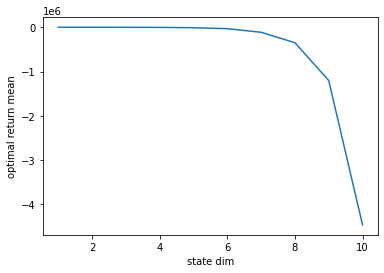

In [26]:
state_dims = np.arange(1, 11)
ctrl_dims = np.full(10, 2, dtype=int)
horizons = np.full(10, 100, dtype=int)
opt_ret_means = optimal_expected_return_matrix(state_dims, ctrl_dims, horizons, clip_ctrl_dim=False).mean(-1)

x = "state dim"; y = "optimal return mean"
data={x: state_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Optimal expected return vs. control dimension

Computing optimal returns by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

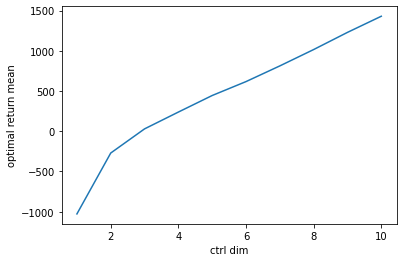

In [27]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.arange(1, 11)
horizons = np.full(10, 100, dtype=int)
opt_ret_means = optimal_expected_return_matrix(state_dims, ctrl_dims, horizons, clip_ctrl_dim=False).mean(-1)

x = "ctrl dim"; y = "optimal return mean"
data = {x: ctrl_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Optimal expected return vs. horizon length

Computing optimal returns by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

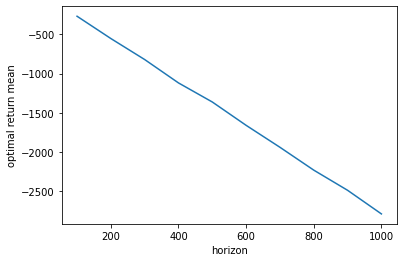

In [28]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.full(10, 2, dtype=int)
horizons = 100 * np.arange(1, 11)
opt_ret_means = optimal_expected_return_matrix(state_dims, ctrl_dims, horizons, clip_ctrl_dim=False).mean(-1)

x = "horizon"; y = "optimal return mean"
data = {x: horizons, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Optimal expected return vs. state & control dimension

Computing optimal returns by LQG dims:   0%|          | 0/20 [00:00<?, ?it/s]

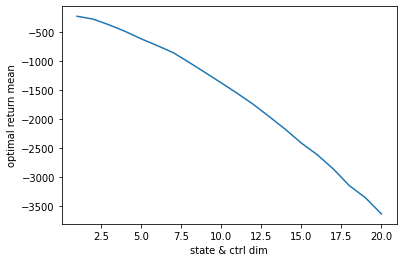

In [30]:
state_dims = ctrl_dims = np.arange(1, 21)
horizons = np.full(20, 100, dtype=int)
opt_ret_means = optimal_expected_return_matrix(state_dims, ctrl_dims, horizons, clip_ctrl_dim=False).mean(-1)

x = "state & ctrl dim"; y = "optimal return mean"
data = {x: state_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

---
## Multivariate analysis of cost scaling

### Checklist
- [x] Plot the average expected return against two variables, e.g., `n_state` and `n_ctrl`, as a 3D surface plot
- [ ] Use the insights gained from observing the cost scaling to propose a _downscaling_ parameter for random QuadCosts
- [ ] Use the analysis above to also derive a scale parameter for the random Gaussian noise for policy generation

In [31]:
def plot_3d_from_2d_function(ax, xrange: np.ndarray, yrange: np.ndarray, function: callable[[np.ndarray, np.ndarray], np.ndarray]):
    length = len(xrange)
    xbatch, ybatch = np.meshgrid(xrange, yrange)
    assert xbatch.shape == ybatch.shape == (length, length)

    x_arr, y_arr = map(lambda x: x.reshape((-1,)), (xbatch, ybatch))
    assert x_arr.shape == y_arr.shape == (length ** 2,), f"expected: {(length ** 2,)}; x_arr: {x_arr.shape}; y_arr {y_arr.shape}"

    z_arr = function(x_arr, y_arr)
    assert z_arr.shape == x_arr.shape, f"{z_arr.shape} != {x_arr.shape}"
    
    zbatch = z_arr.reshape(xbatch.shape)
    ax.plot_surface(xbatch, ybatch, zbatch, cmap=cm.coolwarm)    

### State vs. control dimension with fixed horizon

In what follows we set the horizon length to 100 steps.

<div class="alert alert-block alert-warning">
    <b>Note:</b> we only plot values when control dimensions are at least as large as state dimensions (<code>n_ctrl >= n_state</code>). Having a state dimension much bigger than the control dimension induces very high <b>optimal</b> costs, causing plots to be difficult to read and potential numerical precision errors.
</div>

#### Best expected return

In [33]:
def optimal_performances_by_state_ctrl_dim(state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, horizon: int) -> np.ndarray:
    horizon_arr = np.full_like(state_dim_arr, fill_value=horizon)
    exp_opt_ret_mat = optimal_expected_return_matrix(state_dim_arr, ctrl_dim_arr, horizon_arr, samples=100, clip_ctrl_dim=True)
    return exp_opt_ret_mat

In [34]:
def average_optimal_performance_by_state_ctrl_dim(state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray) -> np.ndarray:
    z_arr = optimal_performances_by_state_ctrl_dim(state_dim_arr, ctrl_dim_arr, horizon=100).mean(axis=-1) 
    # Filtering NaNs
    z_arr = np.nan_to_num(z_arr, nan=np.nanmin(z_arr))
    return z_arr

Computing optimal returns by LQG dims:   0%|          | 0/400 [00:00<?, ?it/s]

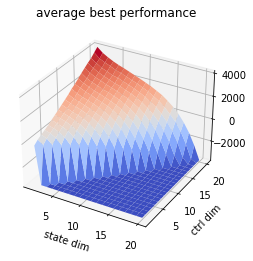

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax, 
    xrange=np.arange(1, 21),
    yrange=np.arange(1, 21),
    function=average_optimal_performance_by_state_ctrl_dim,
)
ax.set_xlabel("state dim")
ax.set_ylabel("ctrl dim")
ax.set_title("average best performance")
plt.show()

#### Expected return from random policy

In [36]:
def policy_performance(policy: lqr.Linear, dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit) -> Tensor:
    return -policy_loss(policy, dynamics, cost, init)

In [37]:
@torch.no_grad()
def random_performance_samples(n_state: int, n_ctrl: int, horizon: int, samples: int = 100) -> np.ndarray:
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=samples)
    policy = sample_policy(dynamics, cost)
    eret = policy_performance(policy, dynamics, cost, init)
    return eret.numpy()

In [38]:
def random_performance_matrix(
    state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, horizon_arr: np.ndarray, samples: int = 100, clip_ctrl_dim: bool = True
) -> np.ndarray:
    random_performance_arrs = []

    pbar = tqdm(
        zip(state_dim_arr, ctrl_dim_arr, horizon_arr), 
        total=len(ctrl_dim_arr), 
        desc="Computing random policy performance vs. LQG dims"
    )
    for n_state, n_ctrl, horizon in pbar:
        if clip_ctrl_dim and n_ctrl < n_state:
            arr = np.full((samples,), fill_value=np.nan)
        else:
            arr = random_performance_samples(n_state, n_ctrl, horizon, samples=samples)
        random_performance_arrs += [arr]

    rand_perf_mat = np.vstack(random_performance_arrs)
    return rand_perf_mat

In [39]:
def random_performances_by_state_ctrl_dim(state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, horizon: int) -> np.ndarray:
    horizon_arr = np.full_like(state_dim_arr, fill_value=horizon)
    rand_perf_mat = random_performance_matrix(state_dim_arr, ctrl_dim_arr, horizon_arr, samples=100, clip_ctrl_dim=True)
    return rand_perf_mat

In [40]:
def average_random_performance_by_state_ctrl_dim(state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray) -> np.ndarray:
    z_arr = random_performances_by_state_ctrl_dim(state_dim_arr, ctrl_dim_arr, horizon=100).mean(axis=-1) 
    # Filtering NaNs
    z_arr = np.nan_to_num(z_arr, nan=np.nanmin(z_arr))
    return z_arr

Computing random policy performance vs. LQG dims:   0%|          | 0/400 [00:00<?, ?it/s]

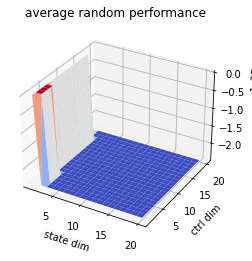

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax, 
    xrange=np.arange(1, 21),
    yrange=np.arange(1, 21),
    function=average_random_performance_by_state_ctrl_dim,
)
ax.set_xlabel("state dim")
ax.set_ylabel("ctrl dim")
ax.set_title("average random performance")
plt.show()

### State & control dimension vs. horizon length

#### Best expected return